

본 연습에서는 non-bayesian nn과 bayesian -nn을 실행한다. 특별히 bayesian-nn 에서는 variational inference(분변추론, information based)와 drop-out 방식을 실행한다. 핵심은 bayesian 방식이 nn에 uncertainty를 추가한다는 것이다.
**Usage:** The idea of the notebook is that you try to understand the provided code by running it, checking the output and playing with it by slightly changing the code and rerunning it.

**Dataset:** Cifar10 dataset을 사용하며, 60'000개 32x32 pixel 로 이루어진 10 개의 class ("airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck")이다. training set에서는 "horse" 이미지를 삭제한 다음, testset에는 남겨놓는다.

**Content:**
* Load the Cifar10 dataset
* Delete all images of the class "horse" from the training dataset
* Split the train dataset into a train and validation dataset (60:40 split) 
* Fit a non-Bayesian NN 
* Fit a Bayesian NN via variational inference 
* Fit a Bayesian NN via dropout 
* Compare the  of the accuracy of the models on the known classes
* Compare the  of the uncertainties of the models on the known and unknown classes
* Use the uncertainties to filter uncertain predictions


In [2]:
import tensorflow as tf
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.5.0  running in colab?:  True


In [3]:
if IN_COLAB:
    !pip install tensorflow_probability==0.8.0

     |████████████████████████████████| 2.5MB 4.2MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7557 sha256=4258a5cbf655f23ff90d3fcea309461668752ad5dd427d869d2f689ecc3f9f0c
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.5.0 has requirement gast==0.4.0, but you'll have gast 0.2.2 which is incompatible.
ERROR: gym 0.17.3 has requirement cloudpickle<1.7.0,>=1.2.0, but you'll have cloudpickle 1.1.1 which is incompatible.
  Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Found existing installation: cloudpickle 1.3.0
    Uninstalling cloudpickle-1.3.0:
      Successfully uninstalled cloudpickle-1.3.0
  Found existing installation: tensorflow-probability 0.12.1
    Uninstalling tensorflow-probability-0.12.1:
      Successfully uninstalled tensorflow-probability-0.12.1


Imports

바로 위의 방식으로tensorflow-probability 페키지 설치에 문제가 있을 수 있으나 이 방법으로 설치는 가능합니다.

In [4]:
 pip install --upgrade tensorflow-probability

     |████████████████████████████████| 4.8MB 4.3MB/s 
  Found existing installation: gast 0.2.2
    Uninstalling gast-0.2.2:
      Successfully uninstalled gast-0.2.2
  Found existing installation: cloudpickle 1.1.1
    Uninstalling cloudpickle-1.1.1:
      Successfully uninstalled cloudpickle-1.1.1
  Found existing installation: tensorflow-probability 0.8.0
    Uninstalling tensorflow-probability-0.8.0:
      Successfully uninstalled tensorflow-probability-0.8.0


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import urllib.request
from sklearn.model_selection import train_test_split
import tensorflow_probability as tfp

%matplotlib inline
plt.style.use('default')

print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)

TFP Version 0.12.2
TF  Version 2.5.0


아랫줄은 tensorflow eager mode를 해제하는 명령어.eager mode를 해제해야 variational inference나 MC dropout 을 하는데 에러가 나지 않습니다.

In [9]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

cifar 10 dataset 로드, 이미 train/test 셋으로 분류가 되어 있으니 따로 지정할 필요 없음. 이미지는 앞서 언급한 대로 작은 것을 알 수 있음.

In [7]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 12s 0us/step


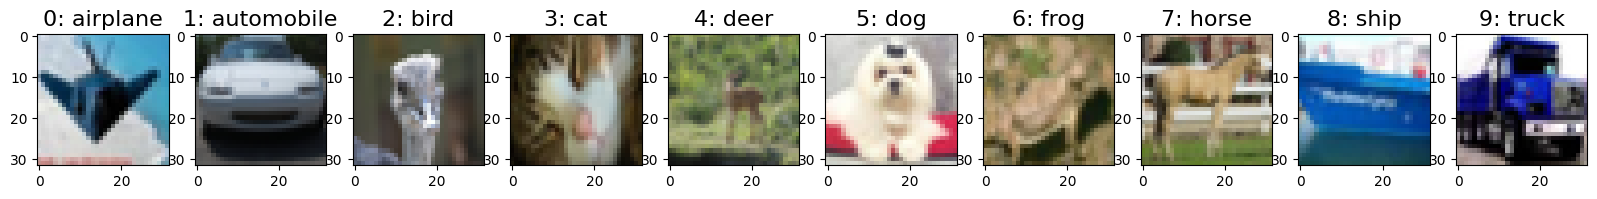

In [11]:
labels=np.array(["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"])
#sample image of each label
np.random.seed(22)
plt.figure(figsize=(20,20))
for i in range(0,len(np.unique(y_train))):
    rmd=np.random.choice(np.where(y_train==i)[0],1)
    plt.subplot(1,10,i+1)
    img=x_train[rmd]
    plt.imshow(img[0,:,:,:])
    plt.title(np.str(y_train[rmd][0][0])+ ": " +labels[i],fontsize=16)
plt.savefig("Figure_8_cifar.pdf")
#from google.colab import files
#files.download('Figure_8_cifar.pdf') 


novel class를 진행하기에 앞서 training set에서 'horse' 이미지를 제거. 따라서 training set 에서는 9개의 class와 각 5000개의 이미지가 있게됨. 이 training set는 3개의 모델 모두에 적용됨.

In [12]:
y_train_no_horse=np.delete(y_train,np.where(y_train==7)[0])
x_train_no_horse=np.delete(x_train,np.where(y_train==7)[0],axis=0)
print(y_train_no_horse.shape)
print(x_train_no_horse.shape)
y_train_no_horse=np.array(pd.get_dummies(y_train_no_horse))
labels_no_horse=np.array(["airplane","automobile","bird","cat","deer","dog","frog","ship","truck"])
print(y_train_no_horse.shape)

(45000,)
(45000, 32, 32, 3)
(45000, 9)


이제 위에서 저장한 45000개의 training set을 다시 6:4 비율로 'training' vs 'validation'으로 나눔. test set에는 10개의 class 와 1만개의 데이터가 있는데, 이때 사라지지 않은 'horse'를 novel class 라고 하며 이 때문에 이와 같이 training set에서  train 되지 않은 class가 test set에 포함되어 classification을 수행하는 작업을 novel classification 이라고 한다. 

In [13]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_no_horse, y_train_no_horse, test_size=0.4, random_state=22)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

#Before training the NNs with the data, we normalize the data to be in the range between -1 and 1. 
x_train=((x_train/255)-0.5)*2
x_val=((x_val/255)-0.5)*2
x_test=((x_test/255)-0.5)*2

x_test.min(), x_test.max()

(27000, 32, 32, 3)
(27000, 9)
(18000, 32, 32, 3)
(18000, 9)
(10000, 32, 32, 3)
(10000, 1)


(-1.0, 1.0)

Non-Bayesian CNN

먼저 베이지안이 아닌 2개 covolution block을 가진 CNN을 학습한다. pooling 조건은 max 이며 3x3 사이즈의 8개 kernel을 첫번째 convolution block 에서 사용하고, 3x3 사이즈의 16개 kernel을 두번째 convolution block 에서 사용한다. maxpooling 사이즈는 2x2 로 즉 0,1을 구분해 내는 작업인 셈이다. training에 시간이 많이 걸리므로 수업시간에도 활용하였듯이 이미 training 된 CNN을 사용한다.



In [14]:
from tensorflow.keras.layers import Convolution2D,MaxPooling2D,Dropout,Flatten,Dense
from tensorflow.keras import Sequential

model = Sequential()
model.add(Convolution2D(8,kernel_size=(3,3),padding="same", activation = 'relu',input_shape=(32,32,3)))
model.add(Convolution2D(8,kernel_size=(3,3),padding="same", activation = 'relu'))
model.add(MaxPooling2D((2,2)))
model.add(Convolution2D(16,kernel_size=(3,3),padding="same", activation = 'relu'))
model.add(Convolution2D(16,kernel_size=(3,3),padding="same", activation = 'relu'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(100, activation = 'relu'))
model.add(Dropout((0.5)))
model.add(Dense(100, activation = 'relu'))
model.add(Dropout((0.5)))
model.add(Dense(9, activation = 'softmax'))

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 8)         224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 8)         584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 16)        1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0

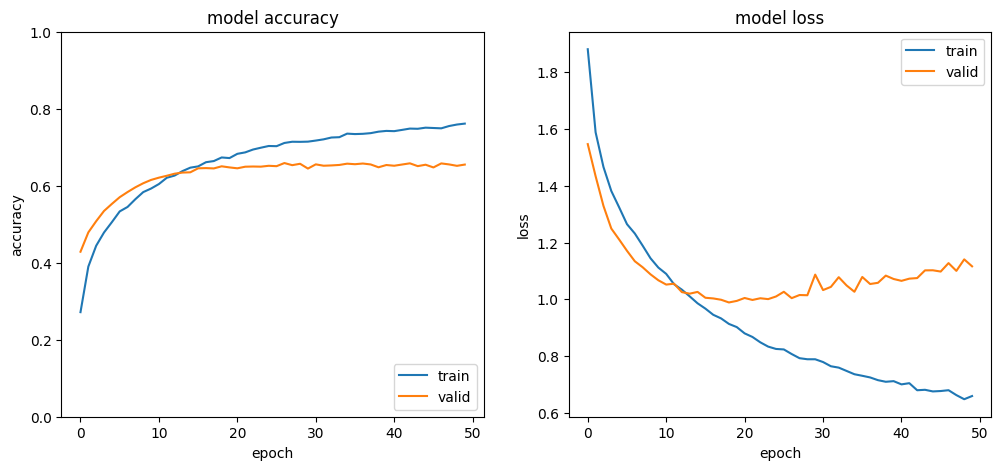

In [15]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/history_baseline_cifar10.csv", "history_baseline_cifar10.csv")
history=np.loadtxt("history_baseline_cifar10.csv",delimiter=",")

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history[:,0])
plt.plot(history[:,1])
plt.ylim(0, 1)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,2)
plt.plot(history[:,2])
plt.plot(history[:,3])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [ ]:
미리 학습된 parameter를 호출함.

In [16]:
# load trained weights of the model
urllib.request.urlretrieve("https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/model_cifar10_weights.hdf5", "model_cifar10_weights.hdf5")
model.load_weights("model_cifar10_weights.hdf5")

 Variational Inference(변분추론)

위의 non-bayesian CNN과 똑같은 구조를 체택한다. 그러나 모든 weight는 이제부터 정규분포로부터 셈플링 된다. 이때 정규분포가 2개의 parameter를 가지므로 주엉해야 하는 파라미터는 2배정도가 된다. 학습 시간이 길어지므로 이때도 미리 학습된 모델을 adjust.

In [17]:
kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (x_train.shape[0] *1.0)

model_vi = Sequential()
model_vi.add(tfp.layers.Convolution2DFlipout(8,kernel_size=(3,3),padding="same", activation = 'relu', kernel_divergence_fn=kernel_divergence_fn,input_shape=(32,32,3)))
model_vi.add(tfp.layers.Convolution2DFlipout(8,kernel_size=(3,3),padding="same", activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
model_vi.add(tf.keras.layers.MaxPooling2D((2,2)))
model_vi.add(tfp.layers.Convolution2DFlipout(16,kernel_size=(3,3),padding="same", activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
model_vi.add(tfp.layers.Convolution2DFlipout(16,kernel_size=(3,3),padding="same", activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
model_vi.add(tf.keras.layers.MaxPooling2D((2,2)))
model_vi.add(tf.keras.layers.Flatten())
model_vi.add(tfp.layers.DenseFlipout(100, activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
model_vi.add(tfp.layers.DenseFlipout(100, activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
model_vi.add(tfp.layers.DenseFlipout(9, activation = 'softmax', kernel_divergence_fn=kernel_divergence_fn))

model_vi.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
model_vi.summary()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1700: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 32, 32, 8)         440       
_________________________________________________________________
conv2d_flipout_1 (Conv2DFlip (None, 32, 32, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_flipout_2 (Conv2DFlip (None, 16, 16, 16)        2320      
_________________________________________________________________
conv2d_flipout_3 (Conv2DFlip (None, 16, 16, 16)        4624      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)             

weight에 uncertainty가 포함되므로 model을 학습할 때 마다 각각의 parameter가 조금씩 변경된다. (아래의 셀을 반복시행해본면 확인 가능)

In [21]:
for i in range(0,5):
  print(model_vi.predict(x_train[0:1])[0])

[0.10905036 0.10566711 0.12834129 0.07741684 0.1066424  0.12624808
 0.1289137  0.07890426 0.13881598]
[0.12990089 0.0964223  0.07989649 0.08204923 0.13073905 0.13917819
 0.10809456 0.07450992 0.15920939]
[0.11774172 0.1213843  0.10070086 0.09187349 0.10942485 0.1318044
 0.10732992 0.09163635 0.12810412]
[0.081003   0.12182645 0.09095127 0.06427141 0.09838926 0.24513598
 0.07687999 0.07282546 0.14871716]
[0.13213831 0.1184409  0.09440621 0.09926875 0.11242177 0.13963266
 0.09605099 0.08572409 0.12191635]


In [ ]:
# Training
# Note that we trained longer for the VI methods, than for the MC Bayes
# from  tensorflow.keras.callbacks import ModelCheckpoint
# fp = "vi_128_lrdefault_weights.{epoch:02d}-{val_loss:.2f}.hdf5"
# cb = ModelCheckpoint(filepath=fp, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=50)
# history=model_vi.fit(x_train, y_train,validation_data=(x_val,y_val), batch_size=128,epochs=700,verbose=1, callbacks=[cb])
# model_vi.save_weights('vi_128_lrdefault.hdf5')
# import pickle
# with open('model_vi_bs_128_lrdefault_hist.pickle', 'wb') as file_pi:
#         pickle.dump(history.history, file_pi)

In [ ]:
미리 학습된 모델 불러오기

In [22]:
# download and load weights of the model
urllib.request.urlretrieve("https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/vi_128_lrdefault.hdf5", "vi_128_lrdefault.hdf5")
model_vi.load_weights("vi_128_lrdefault.hdf5")

# download the history
import pickle
urllib.request.urlretrieve("https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/model_vi_bs_128_lrdefault_hist.pickle", "model_vi_bs_128_lrdefault_hist.pickle")
with open('model_vi_bs_128_lrdefault_hist.pickle', 'rb') as f:
    history = pickle.load(f)

weight가 probablistic(본 경우는 정규분포)하게 sampling되므로 accuracy가 훨씬 wiggly하게 보일 수 있다. 

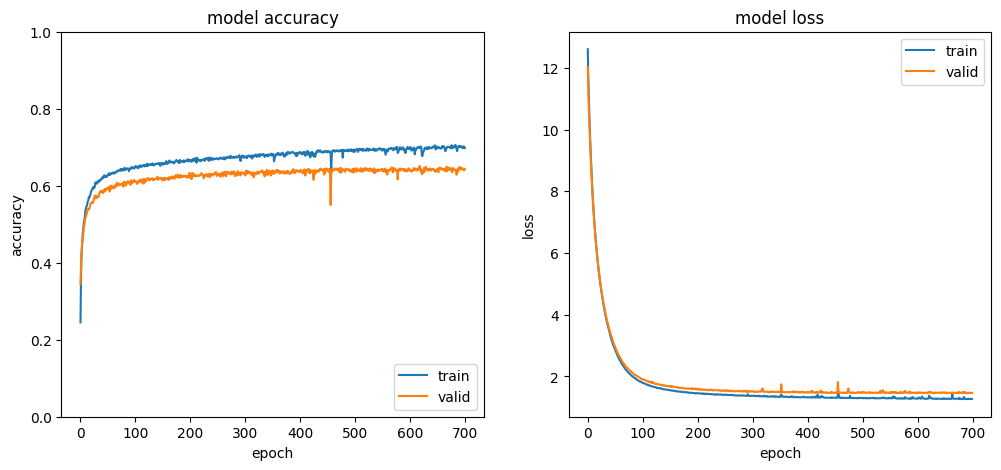

In [23]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
#plt.plot(history[:,0])
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.ylim(0, 1)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,2)
# plt.plot(history[:,2])
# plt.plot(history[:,3])
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.savefig('lr.pdf')

MC Dropout
이번 경우는 drop out을 추가한  bayesian neural network를 시행한다. network frame 에서 달라지는것은 없으나 dropout이 추가된다. 위의 training model과 setting도 똑같다. model setting에 각 레이어 마다 dropout이 추가됨을 볼 수 있다.

In [24]:
model_mc = Sequential()
model_mc.add(Convolution2D(8,kernel_size=(3,3),padding="same", activation = 'relu',input_shape=(32,32,3)))
model_mc.add(Dropout((0.3)))
model_mc.add(Convolution2D(8,kernel_size=(3,3),padding="same", activation = 'relu'))
model_mc.add(Dropout((0.3)))
model_mc.add(MaxPooling2D((2,2)))
model_mc.add(Convolution2D(16,kernel_size=(3,3),padding="same", activation = 'relu'))
model_mc.add(Dropout((0.3)))
model_mc.add(Convolution2D(16,kernel_size=(3,3),padding="same", activation = 'relu'))
model_mc.add(Dropout((0.3)))
model_mc.add(MaxPooling2D((2,2)))
model_mc.add(Flatten())
model_mc.add(Dense(100, activation = 'relu'))
model_mc.add(Dropout((0.3)))
model_mc.add(Dense(100, activation = 'relu'))
model_mc.add(Dropout((0.3)))
model_mc.add(Dense(9, activation = 'softmax'))

model_mc.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

model_mc.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 8)         224       
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 8)         584       
_________________________________________________________________
dropout_3 (Dropout)          (None, 32, 32, 8)         0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 16)        1168      
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 16)       

In the next few cells you define a funtion model_mc_pred, that gives the option to turn the dropout at test time on and off. If you set the learning_phase to 0 you turn the dropout at test time off and if you set it to 1, it on. When it is on, you get a different prediction for the same image in each run. This is because in each run different nodes are randomly deleted. To use it as a bayesian neural network we need to turn the dropout on also at test time.  

Listing 8.5 Getting mc dropout predictions

In [25]:
import tensorflow.keras.backend as K
model_mc_pred = K.function([model_mc.input, K.learning_phase()], [model_mc.output])

In [26]:
#no dropout at test time
for i in range(0,5):
  print(model_mc_pred([x_train[0:1],0])[0])

[[0.11804772 0.11147647 0.11752675 0.11371268 0.11265709 0.11387537
  0.11143977 0.1043189  0.09694523]]
[[0.11804772 0.11147647 0.11752675 0.11371268 0.11265709 0.11387537
  0.11143977 0.1043189  0.09694523]]
[[0.11804772 0.11147647 0.11752675 0.11371268 0.11265709 0.11387537
  0.11143977 0.1043189  0.09694523]]
[[0.11804772 0.11147647 0.11752675 0.11371268 0.11265709 0.11387537
  0.11143977 0.1043189  0.09694523]]
[[0.11804772 0.11147647 0.11752675 0.11371268 0.11265709 0.11387537
  0.11143977 0.1043189  0.09694523]]


In [30]:
#dropout at test time
for i in range(0,5):
  print(model_mc_pred([x_train[0:1],1])[0])

[[0.2241804  0.11195961 0.10367207 0.07742213 0.06663499 0.08951924
  0.19916786 0.07083201 0.05661169]]
[[0.12220334 0.07877328 0.14800423 0.2297042  0.06475034 0.14298342
  0.11140316 0.05028213 0.05189588]]
[[0.27314097 0.11452547 0.10558291 0.07299956 0.11823615 0.11296597
  0.08539373 0.0561336  0.06102163]]
[[0.13122971 0.10262792 0.10612909 0.15514396 0.18847615 0.16026077
  0.06794117 0.04927042 0.03892081]]
[[0.087928   0.05540147 0.15017205 0.1600929  0.14793032 0.15312137
  0.08003814 0.09381133 0.07150435]]


In [ ]:
#history=model_mc.fit(x_train, y_train,validation_data=(x_val,y_val), batch_size=128,epochs=400,verbose=1)

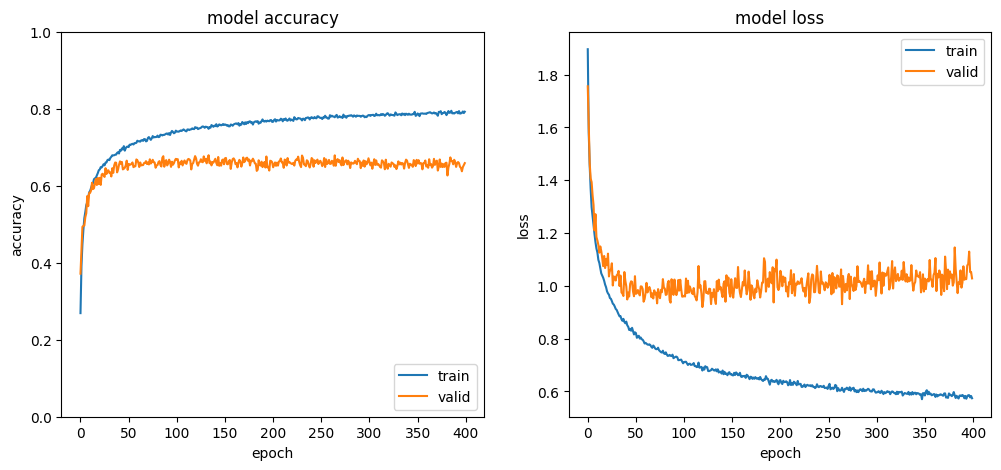

In [31]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/history_mc_cifar10.csv", "history_mc_cifar10.csv")
history=np.loadtxt("history_mc_cifar10.csv",delimiter=",")
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history[:,0])
plt.plot(history[:,1])
plt.ylim(0, 1)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,2)
plt.plot(history[:,2])
plt.plot(history[:,3])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [32]:
# download and load weights of the model
urllib.request.urlretrieve("https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/model_mc_cifar10_weights.hdf5", "model_mc_cifar10_weights.hdf5")
model_mc.load_weights("model_mc_cifar10_weights.hdf5")

Accuracy 비교

In this section you will calculate the accuracies and of all three models. For the non bayesian NN, you will predict every test image once and for the two bayesian NN, you will predict every image 50 times and then takes the mean of all predicted classes. 

Non-bayesian CNN과 variantional inference, 그리고 bayesian droupout을 각자 비교한다. 


아래 셀은 test set의 인덱스를 저장. unknown은 'horse' 

In [33]:
known_idx=np.where(y_test!=7)[0]
unknown_idx=np.where(y_test==7)[0]

print(len(known_idx))
print(len(unknown_idx))

9000
1000


 Non-Bayesian prediction

Non-bayesian CNN의 경우는 하나의 이미지를 복수로 학습할 이유가 없다. parameter가 고정되어 있기 때문에 똑같은 이미지는 복수로 학습한다 하더라도 똑같은 결론이 나오기 때문이다.

In [35]:
pred=model.predict(x_test)
pred_max_p=np.max(pred,axis=1)
entropy=np.array([-np.sum( pred[i] * np.log2(pred[i] + 1E-14)) for i in range(0,len(pred))])
nll_=-np.log(pred_max_p)
pred_labels=np.array([labels_no_horse[np.argmax(pred[i])] for i in range(0,len(pred))])
true_labels=np.array([labels[y_test[i][0]] for i in range(0,len(y_test))])

In [36]:
test_acc_all=np.average(true_labels==pred_labels)
test_acc_known=np.average(true_labels[known_idx]==pred_labels[known_idx])
test_acc_all, test_acc_known

(0.5845, 0.6494444444444445)

Bayesian VI prediction

Bayesian variational inference는 각각의 이미지를 50번씩 반복하여 학습한 다음 mean, s.e.를 구하여 제시한다. 이는 weight가 각각 마다 달라지므로 한개의 이미지가 동일한 결과를 받지 못할 것이기 때문이다. 

In [37]:
pred_vi=np.zeros((len(x_test),9))
pred_max_p_vi=np.zeros((len(x_test)))
pred_std_vi=np.zeros((len(x_test)))
entropy_vi = np.zeros((len(x_test)))

for i in tqdm(range(0,len(x_test))):
  multi_img=np.tile(x_test[i],(50,1,1,1))
  preds=model_vi.predict(multi_img)
  pred_vi[i]=np.mean(preds,axis=0)#mean over n runs of every proba class
  pred_max_p_vi[i]=np.argmax(np.mean(preds,axis=0))#mean over n runs of every proba class
  pred_std_vi[i]= np.sqrt(np.sum(np.var(preds, axis=0)))
  entropy_vi[i] = -np.sum( pred_vi[i] * np.log2(pred_vi[i] + 1E-14)) #Numerical Stability
pred_labels_vi=np.array([labels_no_horse[np.argmax(pred_vi[i])] for i in range(0,len(pred_vi))])
pred_vi_mean_max_p=np.array([pred_vi[i][np.argmax(pred_vi[i])] for i in range(0,len(pred_vi))])
nll_vi=-np.log(pred_vi_mean_max_p)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [41]:
test_acc_all_vi=np.average(true_labels==pred_labels_vi)
test_acc_known_vi=np.average(true_labels[known_idx]==pred_labels_vi[known_idx])
test_acc_all_vi, test_acc_known_vi

(0.6179, 0.6865555555555556)

Bayesian MC prediction

Bayesian MC의 경우도 마찬가지로 50번을 반복하여 평균과 standard deviation을 구하여 제시한다.

In [42]:
pred_mc=np.zeros((len(x_test),9))
pred_max_p_mc=np.zeros((len(x_test)))
pred_std_mc=np.zeros((len(x_test)))
entropy_mc = np.zeros((len(x_test)))

for i in tqdm(range(0,len(x_test))):
  multi_img=np.tile(x_test[i],(50,1,1,1))
  preds=model_mc_pred([multi_img,1])
  pred_mc[i]= np.mean(preds,axis=1)
  pred_max_p_mc[i]=np.argmax(np.mean(preds,axis=1))#mean over n runs of every proba class
  pred_std_mc[i]= np.sqrt(np.sum(np.var(preds, axis=1)))
  entropy_mc[i] = -np.sum( pred_mc[i] * np.log2(pred_mc[i] + 1E-14)) #Numerical Stability
pred_labels_mc=np.array([labels_no_horse[np.argmax(pred_mc[i])] for i in range(0,len(pred_mc))])
pred_mc_mean_max_p=np.array([pred_mc[i][np.argmax(pred_mc[i])] for i in range(0,len(pred_mc))])
nll_mc=-np.log(pred_mc_mean_max_p)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [43]:
test_acc_all_mc=np.average(true_labels==pred_labels_mc)
test_acc_known_mc=np.average(true_labels[known_idx]==pred_labels_mc[known_idx])
test_acc_all_mc, test_acc_known_mc

(0.6333, 0.7036666666666667)

결과를 비교하면 bayseian 모델이 결과가 더 좋음을 볼 수 있다.

In [45]:
import pandas as pd
pd.DataFrame(np.array([[test_acc_known,test_acc_known_vi,test_acc_known_mc],[test_acc_all,test_acc_all_vi,test_acc_all_mc]]), index=['test acc on known labels','test acc on all labels'],columns=['Non-Bayesian','VI','MC'])

,Non-Bayesian,VI,MC
test acc on known labels,0.649444,0.686556,0.703667
test acc on all labels,0.584500,0.617900,0.633300


training set에서 unknown 상태였던 'horse'는 각 모델에서 어떻게 추정되었는지 확인.

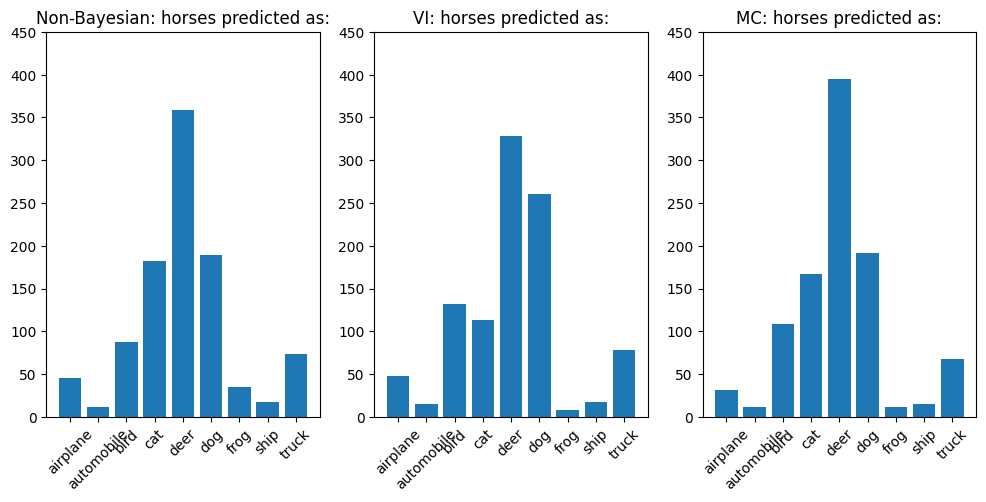

In [46]:
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.bar(np.unique(pred_labels[unknown_idx],return_counts=True)[0],np.unique(pred_labels[unknown_idx],return_counts=True)[1])
plt.xticks(rotation=45)
plt.title("Non-Bayesian: horses predicted as:")
plt.ylim([0,450])

plt.subplot(1,3,2)
plt.bar(np.unique(pred_labels_vi[unknown_idx],return_counts=True)[0],np.unique(pred_labels_vi[unknown_idx],return_counts=True)[1])
plt.xticks(rotation=45)
plt.title("VI: horses predicted as:")
plt.ylim([0,450])

plt.subplot(1,3,3)
plt.bar(np.unique(pred_labels_mc[unknown_idx],return_counts=True)[0],np.unique(pred_labels_mc[unknown_idx],return_counts=True)[1])
plt.xticks(rotation=45)
plt.title("MC: horses predicted as:")
plt.ylim([0,450])

plt.show()

각각의 모델들에서 'horse'는 'deer'로 분류되었음을 알 수 있다. 둘 사이의 공통점이 다른 class보다 많기 때문에 일견 타당한 결과로 생각될 수 있다.

각 모델에 이미지를 input시킨 결과를 보면, non bayesian 의 경우 당연하게도  1을 class의 갯수에 나누어 할당하여 가장 높은 값으로 분류하게 된다. 그러나 베이지안의 경우는 하나의 고정된 값이 아니라 하나의 class에 range로 값이 나타나게 된다. 이때 가장 range가 높을 수록 채택될 확률이 높은 것이다.

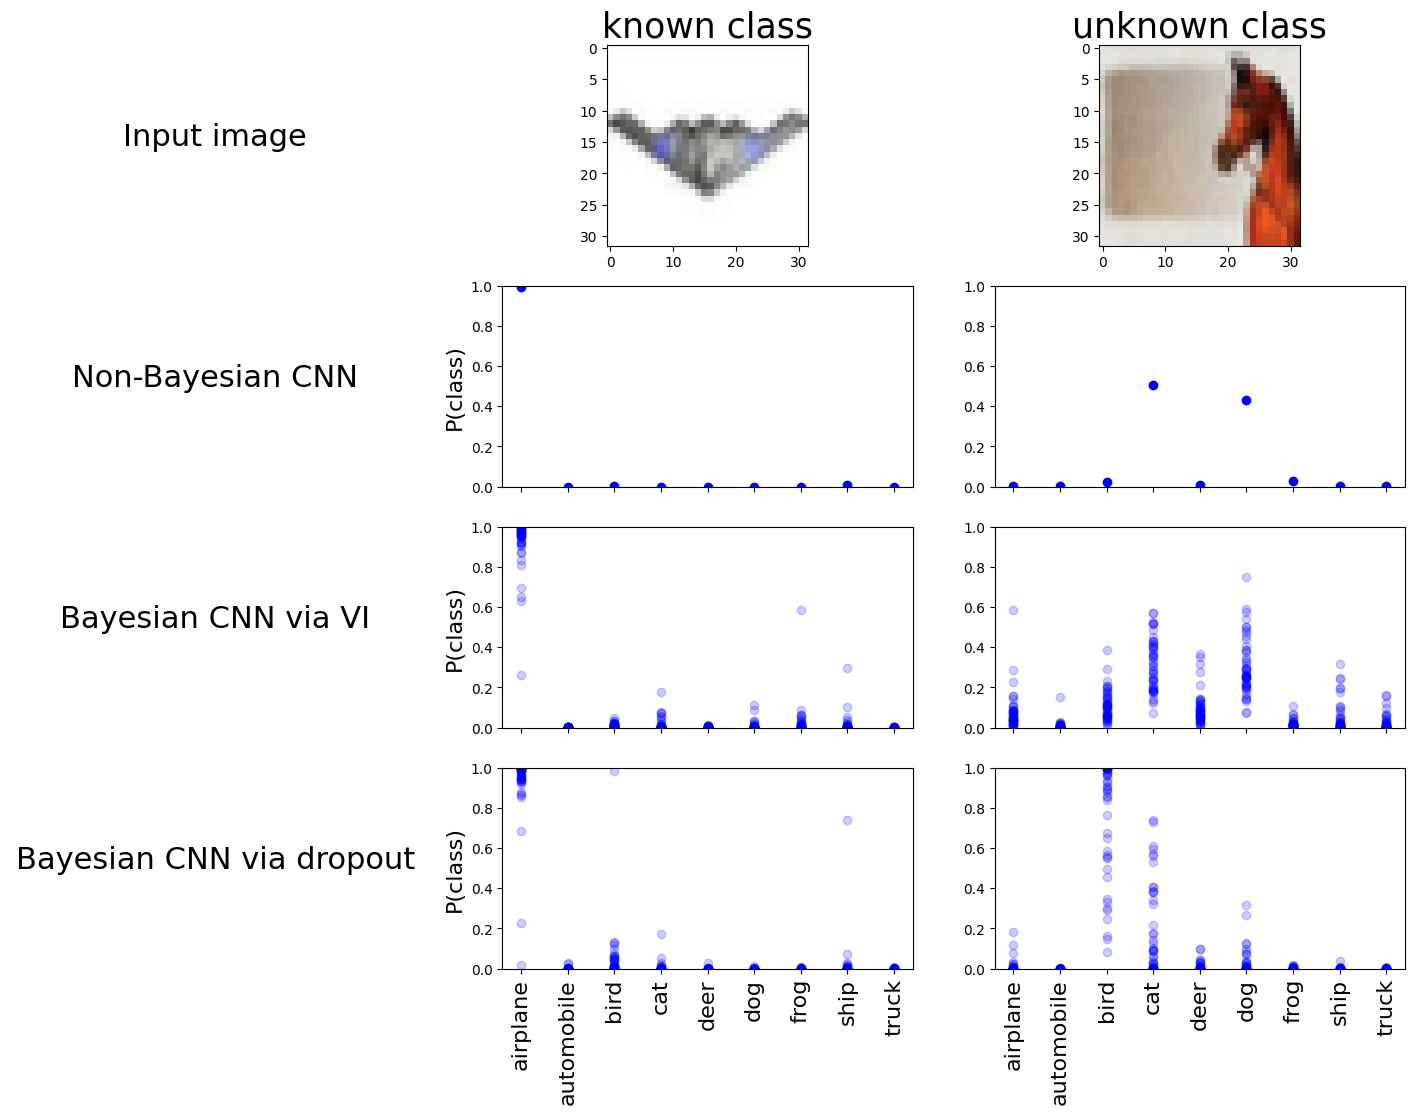

In [47]:
x_test_known = x_test[known_idx]
y_test_known = y_test[known_idx]

x_test_unknown = x_test[unknown_idx]
y_test_unknown = y_test[unknown_idx]

np.random.seed(7681)
random_sample_known=np.random.choice(range(0,len(x_test_known)),1)
np.random.seed(2384)
random_sample_unknown=np.random.choice(range(0,len(x_test_unknown)),1)

plt.figure(figsize=(18,12))
plt.subplot(4,3,1)
plt.axis('off')
plt.text(0.5,0.5, "Input image",fontsize=22,horizontalalignment='center')
plt.subplot(4,3,2)
plt.imshow(np.squeeze(np.array(((((x_test_known[random_sample_known])/2)+0.5)*255),dtype="uint8")))
plt.title("known class",fontsize=25)
plt.subplot(4,3,3)
plt.imshow(np.squeeze(np.array(((((x_test_unknown[random_sample_unknown])/2)+0.5)*255),dtype="uint8")))
plt.title("unknown class",fontsize=25)

plt.subplot(4,3,4)
plt.axis('off')
plt.text(0.5,0.5, "Non-Bayesian CNN",fontsize=22,horizontalalignment='center')
plt.subplot(4,3,5)
plt.scatter(range(0,9),model.predict(x_test_known[random_sample_known]),c="blue")
plt.ylabel("P(class)",fontsize=16)
plt.xticks(range(0,9),labels=np.repeat(" ",9))
plt.ylim([0,1])
plt.subplot(4,3,6)
plt.scatter(range(0,9),model.predict(x_test_unknown[random_sample_unknown]),c="blue")
plt.xticks(range(0,9),labels=np.repeat(" ",9))
plt.ylim([0,1])

plt.subplot(4,3,7)
plt.axis('off')
plt.text(0.5,0.5, "Bayesian CNN via VI",fontsize=22,horizontalalignment='center')
plt.subplot(4,3,8)
for i in range(0,50):
  plt.scatter(range(0,9),model_vi.predict(x_test_known[random_sample_known]),c="blue",alpha=0.2)
plt.xticks(range(0,9),labels=np.repeat(" ",9))
plt.ylim([0,1])
plt.ylabel("P(class)",fontsize=16)
plt.subplot(4,3,9)
for i in range(0,50):
  plt.scatter(range(0,9),model_vi.predict(x_test_unknown[random_sample_unknown]),c="blue",alpha=0.2)
plt.xticks(range(0,9),labels=np.repeat(" ",9))
plt.ylim([0,1])

plt.subplot(4,3,10)
plt.axis('off')
plt.text(0.5,0.5, "Bayesian CNN via dropout",fontsize=22,horizontalalignment='center')
plt.subplot(4,3,11)
for i in range(0,50):
  plt.scatter(range(0,9),model_mc_pred([x_test_known[random_sample_known],1]),c="blue",alpha=0.2)
plt.xticks(range(0,9),labels=labels_no_horse,fontsize=16)
plt.xticks(rotation=90)
plt.ylim([0,1])
plt.ylabel("P(class)",fontsize=16)
plt.subplot(4,3,12)
for i in range(0,50):
  plt.scatter(range(0,9),model_mc_pred([x_test_unknown[random_sample_unknown],1]),c="blue",alpha=0.2)
plt.xticks(range(0,9),labels=labels_no_horse,fontsize=16)
plt.xticks(rotation=90)
plt.ylim([0,1])
plt.savefig("8.good2.pdf")
plt.show()
#from google.colab import files
#files.download('8.good2.pdf') 

##### Unknown and known classes

In [49]:
def plot_hists(dist, title, xlabel, xlim=None):
    plt.hist(dist[unknown_idx],bins=30, density=True,alpha = 0.7)
    plt.hist(dist[known_idx],bins=30,  density=True,alpha = 0.7)
    plt.title(title)
    plt.legend(['unknown','known'])
    plt.xlabel(xlabel)
    if xlim != None:
        plt.xlim(xlim)

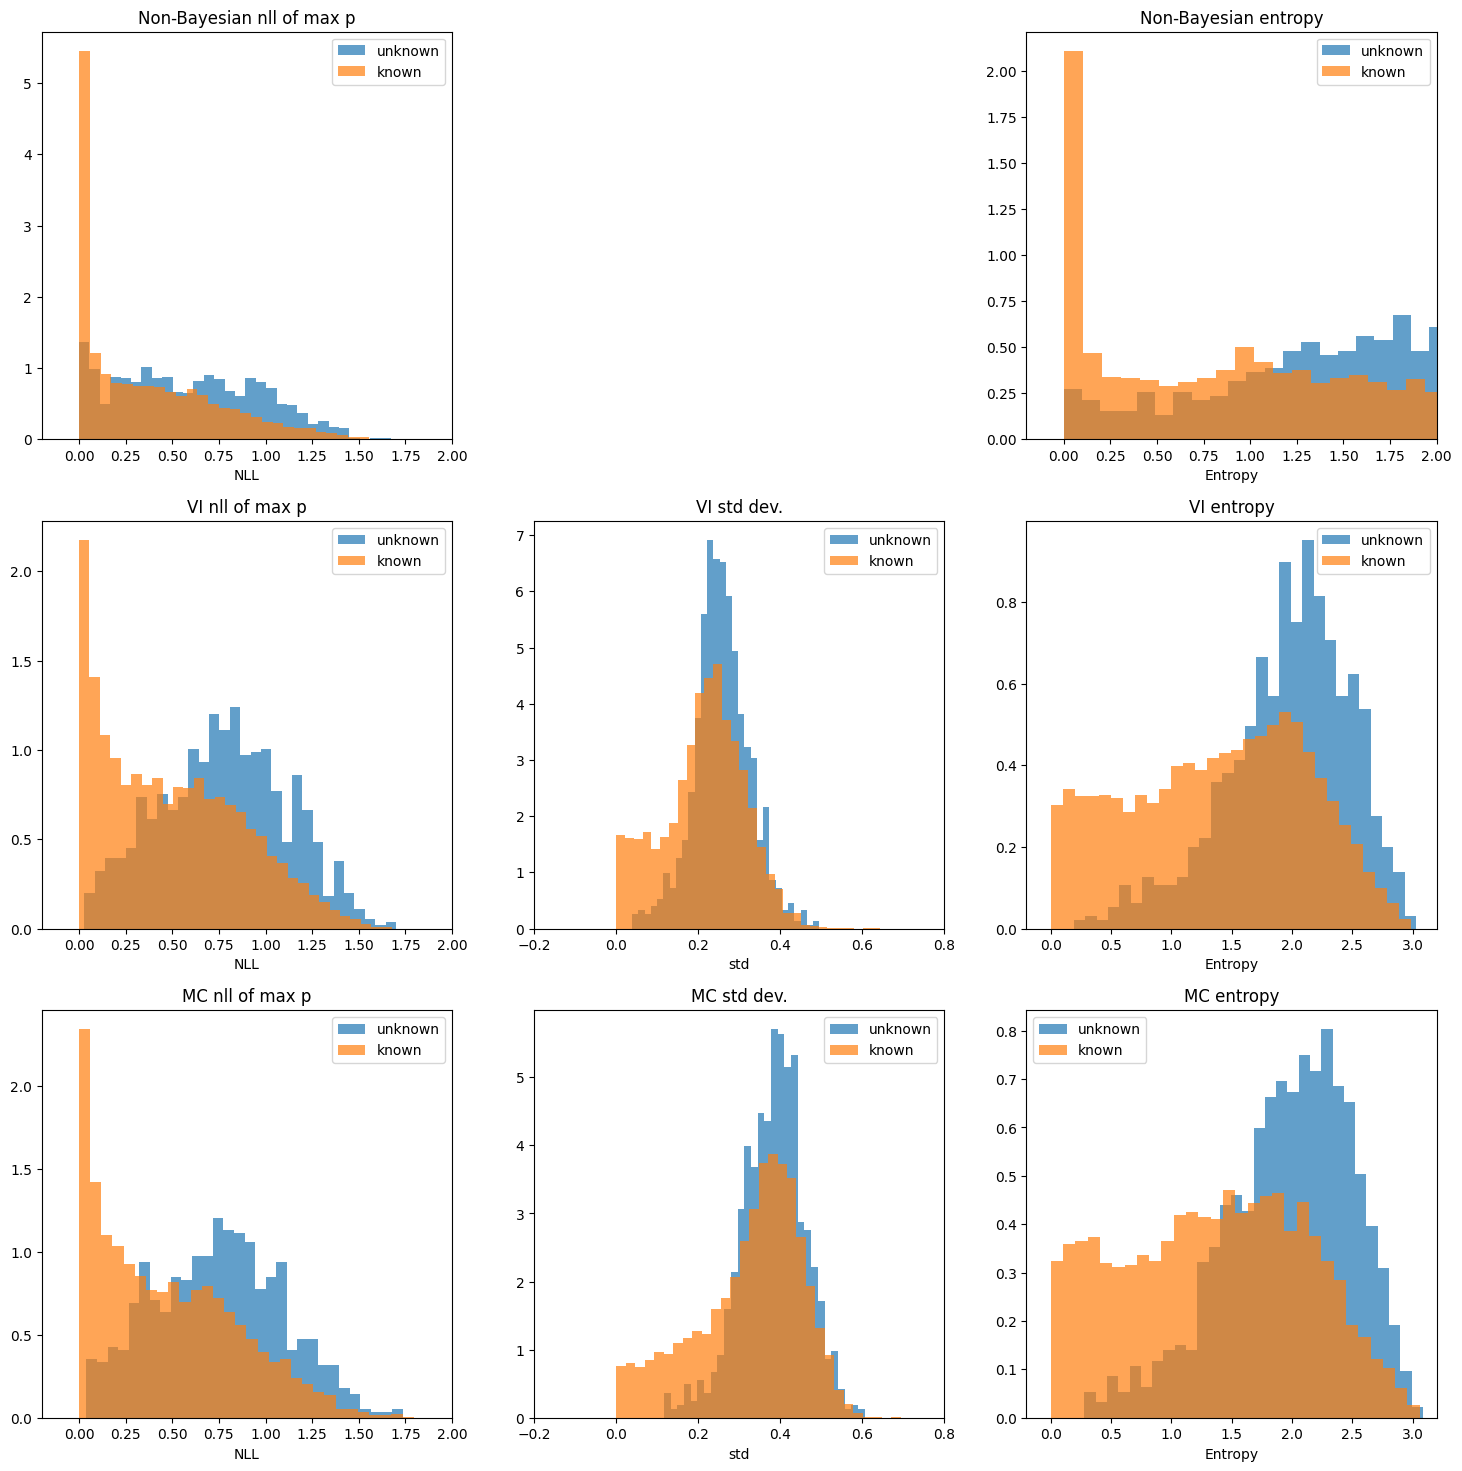

In [50]:
plt.figure(figsize=(18,18))

# Non-Bayesian
plt.subplot(3,3,1)
plot_hists(nll_, "Non-Bayesian nll of max p", "NLL", [-0.2,2])
plt.subplot(3,3,2)
plt.axis("off")
plt.subplot(3,3,3)
plot_hists(entropy, "Non-Bayesian entropy", "Entropy", [-0.2,2])

# VI
plt.subplot(3,3,4)
plot_hists(nll_vi, "VI nll of max p", "NLL", [-0.2,2])
plt.subplot(3,3,5)
plot_hists(pred_std_vi, "VI std dev.", "std", [-0.2,0.8])
plt.subplot(3,3,6)
plot_hists(entropy_vi, "VI entropy", "Entropy", [-0.2,3.2])

# MC Methods
plt.subplot(3,3,7)
plot_hists(nll_mc, "MC nll of max p", "NLL", [-0.2,2])
plt.subplot(3,3,8)
plot_hists(pred_std_mc, "MC std dev.", "std", [-0.2,0.8])
plt.subplot(3,3,9)
plot_hists(entropy_mc, "MC entropy", "Entropy", [-0.2,3.2])

plt.show()

위의 그림에서 보는 바와 같이 non-bayesian 과 bayesian의 uncertainty가 확실히 차이가 보임을 알 수 있다. bayesian의 경우가 좀더 probablistic 한 모습(deviation이 있는)을 보인다.

Use the uncertainty measures as filter

In the next cells you will use the uncertainty measures as filter. You will sort the predicitons by the uncertainty measures and calcualte the accuracy on the n most certrain images. You will compare all three models based on this accuracy vs most certain images plot. To simplify the the sorting and plotting, we first define a the function plot_certainty_idx_filter. 



In [ ]:
def plot_certainty_idx_filter(nr_of_best,certainty_measure,prediction,color,linetype):
  certainty_idx = np.argsort(certainty_measure.reshape(len(certainty_measure)))
  acc_nbest = np.zeros((nr_of_best))
  for j in (range(0,nr_of_best)):
    acc_nbest[j]=np.average(prediction[certainty_idx[0:j]]==true_labels[certainty_idx[0:j]])
  plt.plot(acc_nbest,c=color,linewidth=2,linestyle=linetype)
  plt.ylim([0.5,1.05])
  plt.ylabel('accuracy',fontsize=14)
  plt.xlabel('Number of Examples taken',fontsize=14)

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mea

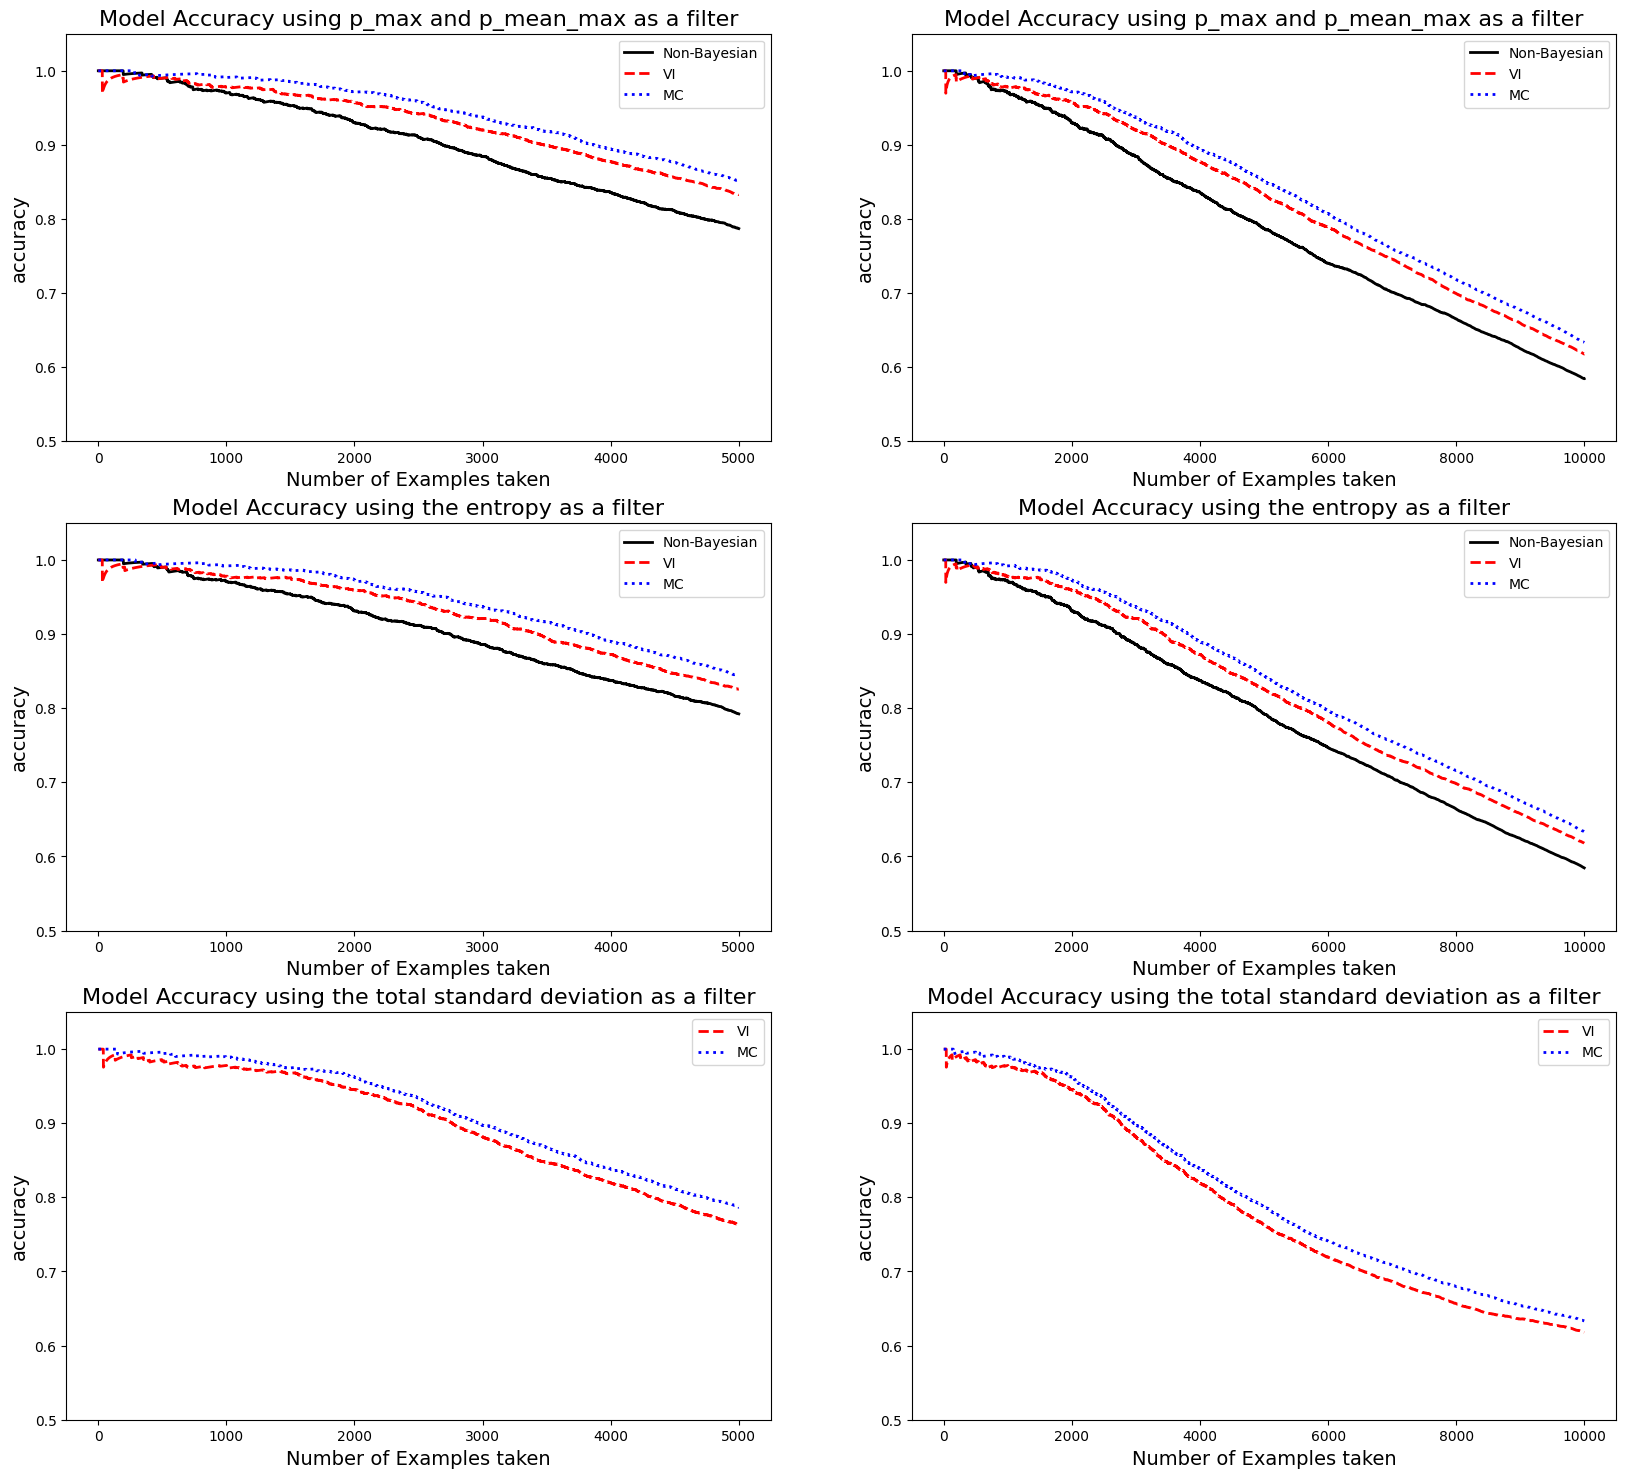

In [ ]:
plt.figure(figsize=(20,18))
plt.subplot(3,2,1)
plot_certainty_idx_filter(5000,nll_,pred_labels,'black','solid')
plot_certainty_idx_filter(5000,nll_vi,pred_labels_vi,'red','dashed')
plot_certainty_idx_filter(5000,nll_mc,pred_labels_mc,'blue','dotted')
plt.title('Model Accuracy using p_max and p_mean_max as a filter',fontsize=16)
plt.legend(['Non-Bayesian', 'VI',"MC"], loc='upper right')

plt.subplot(3,2,2)
plot_certainty_idx_filter(10000,nll_,pred_labels,'black','solid')
plot_certainty_idx_filter(10000,nll_vi,pred_labels_vi,'red','dashed')
plot_certainty_idx_filter(10000,nll_mc,pred_labels_mc,'blue','dotted')
plt.title('Model Accuracy using p_max and p_mean_max as a filter',fontsize=16)
plt.legend(['Non-Bayesian', 'VI',"MC"], loc='upper right')

plt.subplot(3,2,3)
plot_certainty_idx_filter(5000,entropy,pred_labels,'black','solid')
plot_certainty_idx_filter(5000,entropy_vi,pred_labels_vi,'red','dashed')
plot_certainty_idx_filter(5000,entropy_mc,pred_labels_mc,'blue','dotted')
plt.title('Model Accuracy using the entropy as a filter',fontsize=16)
plt.legend(['Non-Bayesian', 'VI',"MC"], loc='upper right')

plt.subplot(3,2,4)
plot_certainty_idx_filter(10000,entropy,pred_labels,'black','solid')
plot_certainty_idx_filter(10000,entropy_vi,pred_labels_vi,'red','dashed')
plot_certainty_idx_filter(10000,entropy_mc,pred_labels_mc,'blue','dotted')
plt.title('Model Accuracy using the entropy as a filter',fontsize=16)
plt.legend(['Non-Bayesian', 'VI',"MC"], loc='upper right')

plt.subplot(3,2,5)
plot_certainty_idx_filter(5000,pred_std_vi,pred_labels_vi,'red','dashed')
plot_certainty_idx_filter(5000,pred_std_mc,pred_labels_mc,'blue','dotted')
plt.title('Model Accuracy using the total standard deviation as a filter',fontsize=16)
plt.legend(['VI',"MC"], loc='upper right')

plt.subplot(3,2,6)
plot_certainty_idx_filter(10000,pred_std_vi,pred_labels_vi,'red','dashed')
plot_certainty_idx_filter(10000,pred_std_mc,pred_labels_mc,'blue','dotted')
plt.title('Model Accuracy using the total standard deviation as a filter',fontsize=16)
plt.legend(['VI',"MC"], loc='upper right')
plt.savefig("8.filter.pdf")
plt.show()
#from google.colab import files
#files.download('8.filter.pdf')

You see that both bayesian models outperform the non-bayesian model. This means the bayesian model are more appropriate when you want to have an uncertainty measures. Note again that the mc-dropout model is the best model also in this case.